In [13]:
import pandas as pd
df_original = pd.read_csv("../src/taxipred/data/cleaned_data.csv", index_col=0)
df_original.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,Clear,3.48,0.51,0.15,116.81,36.4698
4,25.83,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180
5,8.64,Afternoon,Weekend,2.0,Medium,Clear,2.55,1.71,0.48,89.33,60.2028


In [14]:
df_original.info()


<class 'pandas.core.frame.DataFrame'>
Index: 923 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       923 non-null    float64
 1   Time_of_Day            923 non-null    object 
 2   Day_of_Week            923 non-null    object 
 3   Passenger_Count        923 non-null    float64
 4   Traffic_Conditions     923 non-null    object 
 5   Weather                923 non-null    object 
 6   Base_Fare              923 non-null    float64
 7   Per_Km_Rate            923 non-null    float64
 8   Per_Minute_Rate        923 non-null    float64
 9   Trip_Duration_Minutes  923 non-null    float64
 10  Trip_Price             923 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.5+ KB


### Is the data normally distributed? 

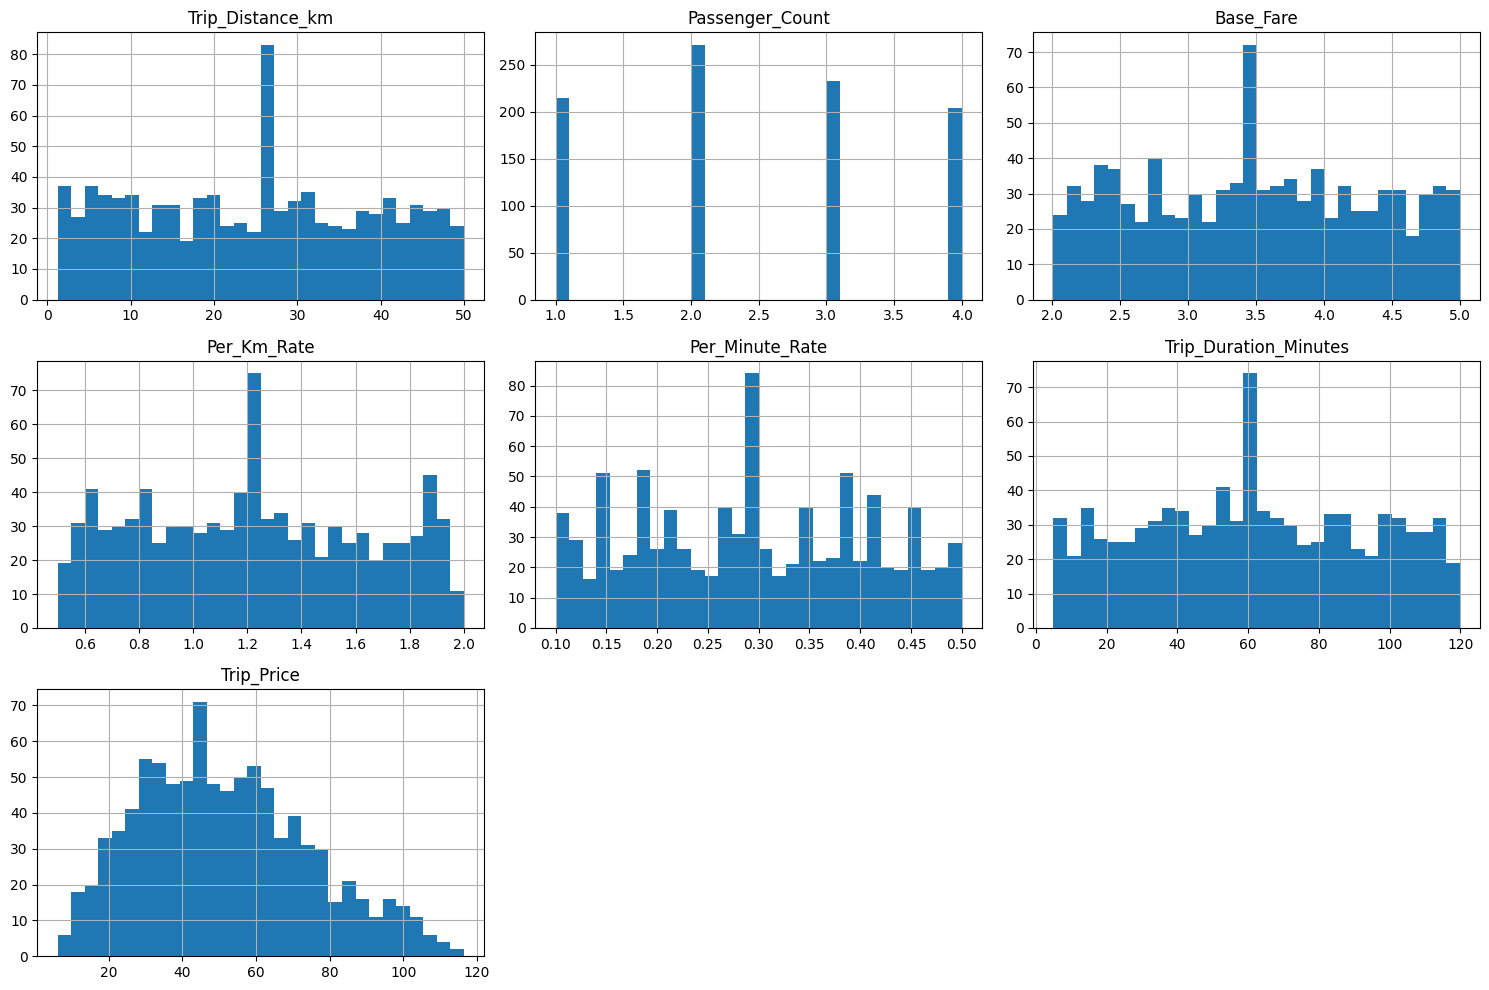

In [15]:
import matplotlib.pyplot as plt

df_original.hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()

## Encoding

In [16]:
df_encoded = pd.get_dummies(df_original, drop_first=True)
df_encoded.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,False,True,False,False,True,False,False,False
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,True,False,False,True,False,False,False,False
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,True,False,False,False,True,False,False,False
4,25.83,3.0,2.93,0.63,0.32,22.64,15.6180,True,False,False,False,False,False,False,False
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,False,False,False,True,False,True,False,False


#### Train|test|val split

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

X, y = df_encoded.drop(columns="Trip_Price"), df_encoded["Trip_Price"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42) #X_train_full använder du när du utvärderar alla modeller
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.11, random_state=42)
X_train_full.shape, X_train.shape, X_test.shape, X_val.shape, y_train_full.shape, y_train.shape, y_test.shape, y_val.shape


((830, 14), (738, 14), (93, 14), (92, 14), (830,), (738,), (93,), (92,))

## Scale data

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_val = scaler.transform(X_val)
scaled_X_train.shape, scaled_X_test.shape, scaled_X_val.shape



((738, 14), (93, 14), (92, 14))

In [19]:
print(f"{scaled_X_train.max()=:.3f}")
print(f"{scaled_X_train.min()=:.3f}")
print(f"{scaled_X_train.std()=:.3f}\n")
print(f"{scaled_X_test.max()=:.3f}")
print(f"{scaled_X_test.min()=:.3f}")
print(f"{scaled_X_test.std()=:.3f}\n")
print(f"{scaled_X_val.max()=:.3f}")
print(f"{scaled_X_val.min()=:.3f}")
print(f"{scaled_X_val.std()=:.3f}")

scaled_X_train.max()=4.071
scaled_X_train.min()=-1.778
scaled_X_train.std()=1.000

scaled_X_test.max()=4.071
scaled_X_test.min()=-1.732
scaled_X_test.std()=1.018

scaled_X_val.max()=4.071
scaled_X_val.min()=-1.777
scaled_X_val.std()=0.987


## Find K for KNeighborsRegressor

In [20]:
# from sklearn.metrics import accuracy_score

errors = []
for i in range(1,50): 
    model_find_k = KNeighborsRegressor(n_neighbors=i)
    model_find_k.fit(scaled_X_train, y_train)
    y_pred = model_find_k.predict(scaled_X_val)
    error = root_mean_squared_error(y_val, y_pred)
    errors.append(error)
errors[:10]

[16.191501160539104,
 14.545001177759751,
 14.168908819264637,
 13.755312337257045,
 13.674207256071714,
 13.856587229923974,
 13.403434135683975,
 13.403630294936987,
 13.123556170499274,
 13.294935848783943]

<Axes: >

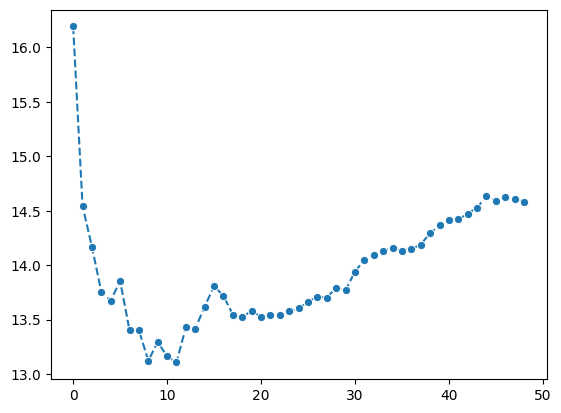

In [21]:
import seaborn as sns
sns.lineplot(errors, marker="o",linestyle="--")

In [22]:
best_index = min(errors)
best_k = errors.index(best_index) +1
print("Best value for k: ", best_k)

Best value for k:  12


In [31]:
models = {
"LinearRegression": LinearRegression(),
"RidgeCV": RidgeCV(),
"ElasticNetCV": ElasticNetCV(),
"KNeighborsRegressor": KNeighborsRegressor(n_neighbors=best_k),
"RandomForestRegressor": RandomForestRegressor(),
"XGBRegressor": XGBRegressor()
}

scaler = StandardScaler()

scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
result = []
for key, model in models.items(): 
    model.fit(scaled_X_train, y_train)
    y_pred = model.predict(scaled_X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    # diff = y_pred[0] - y_test.iloc[0] #räkna ut diff på första[0]
    
    result.append([key, mae, mse, rmse])#, y_pred[0], y_test.iloc[0], diff])
    
df_metric = pd.DataFrame(result, columns=["model", "mae", "mse", "rmse"])
df_metric.sort_values(by="rmse")


,model,mae,mse,rmse
5,XGBRegressor,4.893943,45.529313,6.747541
4,RandomForestRegressor,4.973228,46.217630,6.798355
2,ElasticNetCV,6.803223,71.426296,8.451408
1,RidgeCV,6.799320,71.627307,8.463292
0,LinearRegression,6.800076,71.657769,8.465091
3,KNeighborsRegressor,10.686921,171.790438,13.106885


## Chosen model: XGBOOST